In [20]:
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
import segmentation_models as sm
from tensorflow.keras.metrics import MeanIoU
import random
from PIL import Image
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from tensorflow import keras
import time
from sklearn.preprocessing import LabelEncoder

In [3]:
basepath = 'C:/Users/exebeche/Desktop/basepath/'
###train

valid_img_directory = basepath + 'test/patches/'
valid_msk_directory = basepath + 'test/patches_msk/'


valid_img_list = os.listdir(valid_img_directory)
print(len(valid_img_list))
valid_msk_list = os.listdir(valid_msk_directory)
print(len(valid_msk_list))

6145
6145


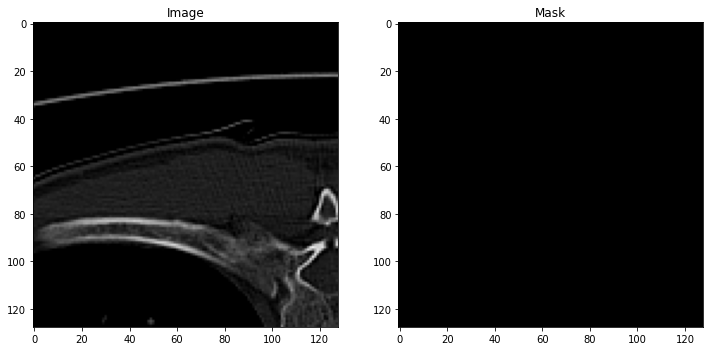

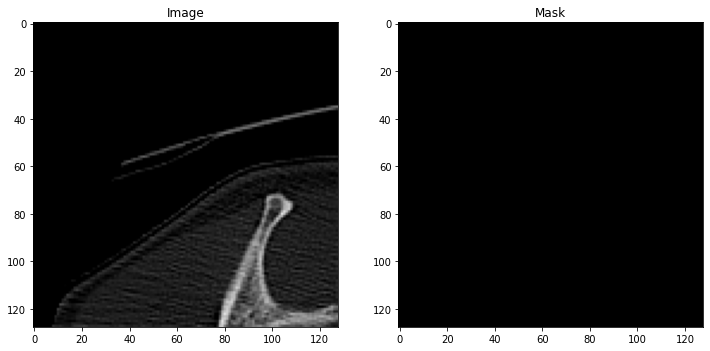

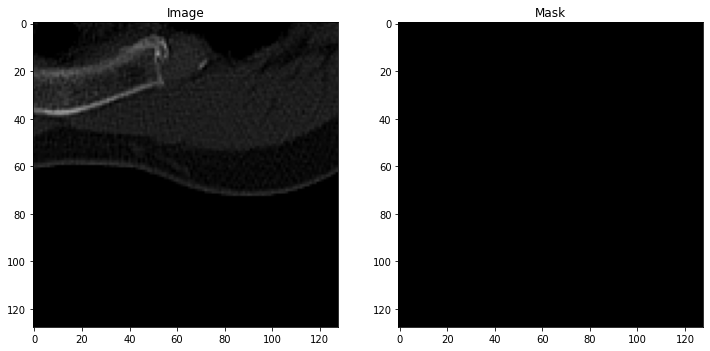

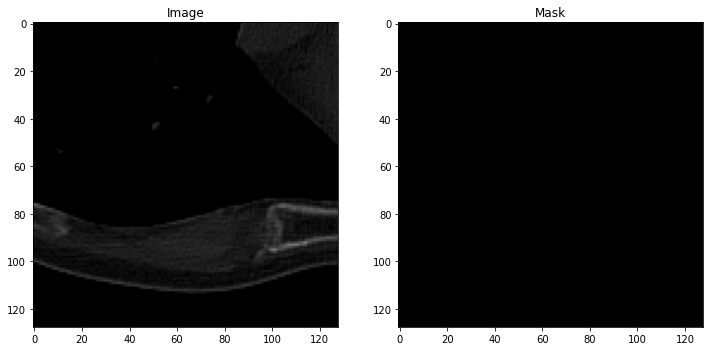

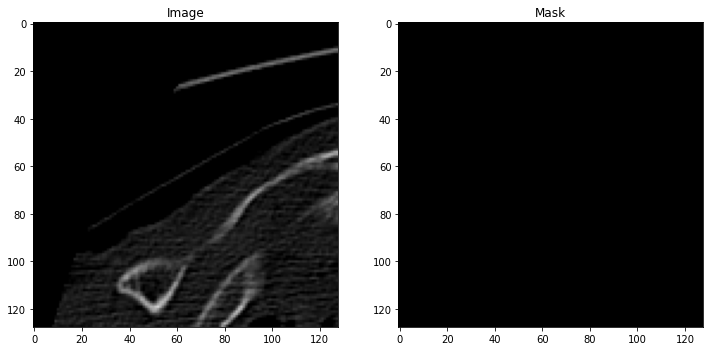

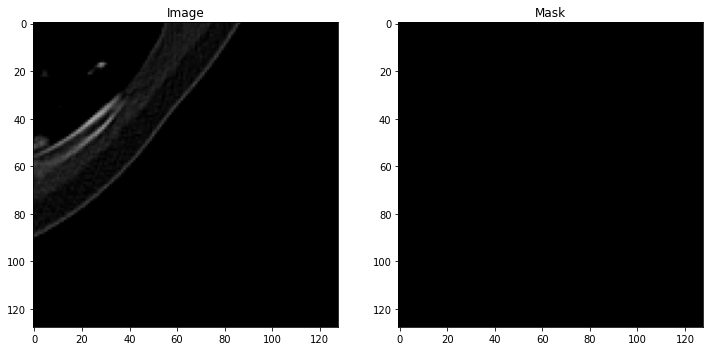

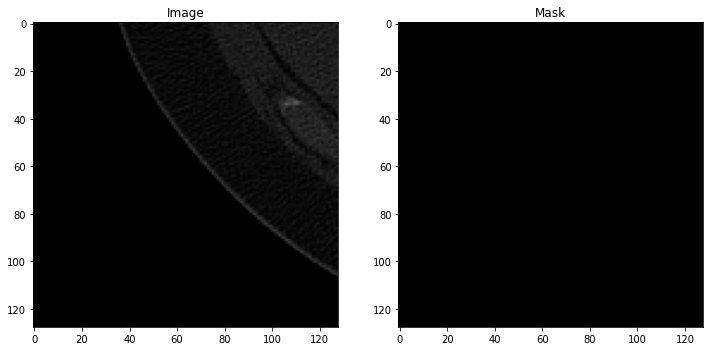

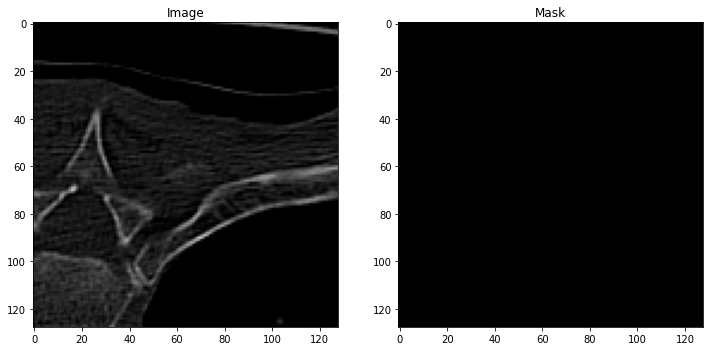

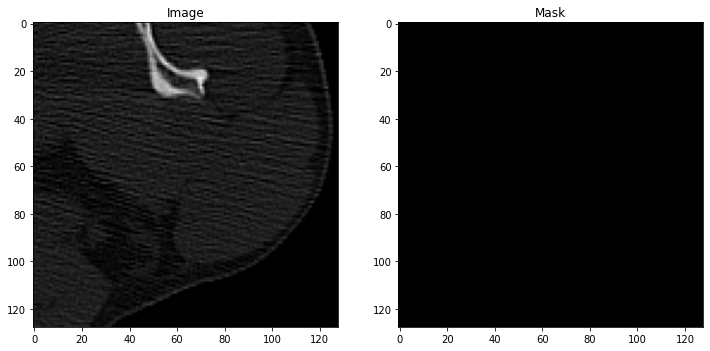

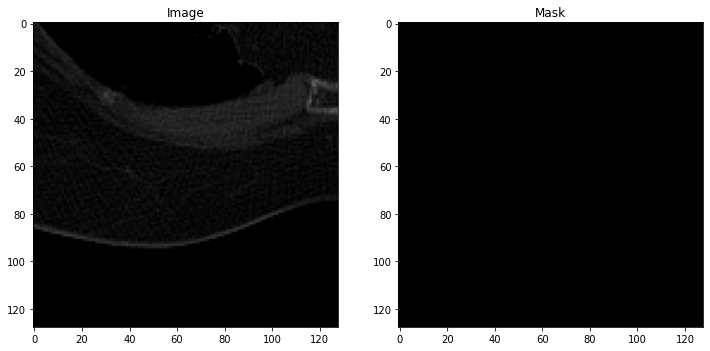

In [4]:
for i in range(0, 10):
    num_images = len(valid_img_list)

    img_num = random.randint(0, num_images-1)

    img_for_plot = cv2.imread(valid_img_directory + valid_img_list[img_num], 1)
    img_for_plot = cv2.cvtColor(img_for_plot, cv2.COLOR_BGR2RGB)

    mask_for_plot =cv2.imread(valid_msk_directory + valid_msk_list[img_num], 0)

    plt.figure(figsize=(12, 8))
    plt.subplot(121)
    plt.imshow(img_for_plot)
    plt.title('Image')
    plt.subplot(122)
    plt.imshow(mask_for_plot, cmap='gray')
    plt.title('Mask')
    plt.show()

In [22]:
%%time
valid_images = []

for img in os.listdir(valid_img_directory):
    if(os.path.isfile(valid_img_directory + img)):
        img = cv2.imread(valid_img_directory + img, 1)
        valid_images.append(np.array(img))

valid_images = np.array(valid_images)

from PIL import Image

valid_masks = []

for img in os.listdir(valid_msk_directory):
    if(os.path.isfile(valid_msk_directory + img)):
        image = Image.open(valid_msk_directory + img)
        valid_masks.append(np.array(image))

valid_masks = np.array(valid_masks)
labelencoder = LabelEncoder()
n, h, w = valid_masks.shape

valid_masks_reshaped = valid_masks.reshape(-1,1)
valid_masks_reshaped_encoded = labelencoder.fit_transform(valid_masks_reshaped)
valid_masks_encoded_original_shape = valid_masks_reshaped_encoded.reshape(n, h, w)
y_valid = np.expand_dims(valid_masks_encoded_original_shape, axis=3)

C:\Users\exebeche\anaconda3\envs\py37gpu\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Wall time: 9.15 s


In [32]:
#Use this to preprocess input for transfer learning
BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)
models_path = 'C:/Users/exebeche/Desktop/Сalcifications/models/' # directory with models

X_valid = preprocess_input(valid_images)
y_valid = np.float32(y_valid)

In [33]:
models_lits = os.listdir(models_path)
models = []

for i in range(0, len(models_lits)):
    model = keras.models.load_model(models_path + models_lits[i], compile = False)
    models.append(model)

In [34]:
preds = [model.predict(X_valid) for model in models]
preds=np.array(preds)
summed = np.sum(preds, axis=0)

In [35]:
weights = [0.27, 0.23, 0.25, 0.25]

In [36]:
preds.shape

(4, 6144, 128, 128, 1)

In [37]:
weighted_preds = np.tensordot(preds, weights, axes=((0),(0)))
weighted_ensemble_prediction = np.argmax(weighted_preds, axis=3)

In [38]:
prediction_ = weighted_preds
y_pred_thresholded = prediction_ > 0.5
intersection = np.logical_and(y_valid, y_pred_thresholded)
union = np.logical_or(y_valid, y_pred_thresholded)
iou_score = np.sum(intersection) / np.sum(union)
print(" IoU socre is: ", iou_score)

 IoU socre is:  0.7239995662075697
